In [1]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model, normalize
from keras.layers import Dense, Input, GlobalMaxPooling1D, BatchNormalization, CuDNNLSTM, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, SpatialDropout1D, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, advanced_activations, SpatialDropout2D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, Adadelta
from keras.models import Model, Sequential
from keras import regularizers

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Gensim
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.utils import simple_preprocess

# Other
from IPython.display import Image # plotting within the notebook
import numpy as np # linear algebra
import os
import re # regular expressions
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # progress bar
from collections import Counter # counting of words in the texts
import operator 
import dateutil.parser as dparser # access the time
tqdm.pandas()

Using TensorFlow backend.


### Reading the data

In [2]:
columns = ["target", "ids", "date", "flag", "user", "text"]
name = os.listdir("../input")[1]
path = os.path.join("..","input",name)
p = os.path.join("..","input",name,os.listdir(path)[0])
print(p)
data = pd.read_csv(p, encoding='latin1', header=None, names=columns, engine='python')

../input/sentiment140/training.1600000.processed.noemoticon.csv


First look at the raw data

In [3]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data["sentiment"] = data["target"].map({0: 0, 4: 1})

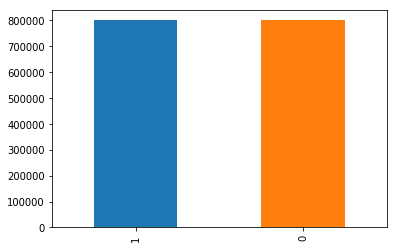

In [5]:
fig, ax = plt.subplots()
data['sentiment'].value_counts().plot(ax=ax, kind='bar')
# no over- or undersampling needed

# Feature Engineering

In [6]:
all_text_without_sw = ''
for i in data.itertuples():
    all_text_without_sw = all_text_without_sw + str(i.text)

In [7]:
tokenized_all_text = nltk.word_tokenize(all_text_without_sw) # tokenize the text --> takes a very long time
list_of_tagged_words = nltk.pos_tag(tokenized_all_text) # adding POS Tags to tokenized words
set_pos  = (set(list_of_tagged_words)) # set of POS tags & words

In [8]:
# Feature 1: POS tagging
#POS tags of nouns
nouns = ['NN','NNS','NNP','NNPS'] 
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  nouns, set_pos)))
data['pos_nouns'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )
# POS tags of pronouns
pronouns = ['PRP','PRP$','WP','WP$'] 
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  pronouns, set_pos)))
data['pos_pronouns'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )
#POS tags of verbs
verbs = ['VB','VBD','VBG','VBN','VBP','VBZ'] 
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  verbs, set_pos)))
data['pos_verbs'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )
#POS tags of adjectives
adjectives = ['JJ','JJR','JJS'] 
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adjectives, set_pos)))
data['pos_adjectives'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))
#POS tags of adverbs
adverbs = ['RB','RBR','RBS','WRB'] 
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adverbs, set_pos)))
data['pos_adverbs'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))
del [set_pos, list_of_tagged_words, tokenized_all_text, all_text_without_sw]

In [9]:
def time(x):
    return dparser.parse(x,fuzzy=True).hour

In [10]:
# Feature 2: hour of the day
data["hour"] = data["date"].progress_apply(lambda x: time(x))

  0%|          | 0/1600000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
100%|██████████| 1600000/1600000 [03:48<00:00, 7014.26it/s]


In [11]:
# Feature 3: number of tokens of a tweet
data['no_tokens'] = data['text'].apply(lambda x: len(x.split()))

In [12]:
# Feature 4: number of characters in a tweet
data['no_chars'] = data['text'].apply(lambda x: len(x))

In [13]:
# Feature 5: average length of words
data['avg_token'] = data['no_chars'] / data['no_tokens']

Normalizing the numerical features

In [14]:
for c in ["no_tokens","no_chars","avg_token","pos_adverbs","pos_nouns","pos_verbs","pos_pronouns","pos_adjectives","hour"]:
    data[c]=(data[c]-data[c].min())/(data[c].max()-data[c].min())

Further ideas:
- counting the number of stopwords
- counting the top words used
- counting the least used words
- count of upper case words
- Trigrams to identify top ten trigrams from text and check for its usage
- using the time (e.g. time of day)

# Reading the Word embeddings

In [15]:
name = os.listdir("../input")[0]
path = os.path.join("..","input",name,'GoogleNews-vectors-negative300.bin')
print(path)
word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)

../input/google-w2v/GoogleNews-vectors-negative300.bin


## Checking the word coverage
The process of achieving a high coverage can not be automated

In [16]:
def check_coverage(vocab,embeddings_index):
    a,oov = {},{}
    k,l = 0,0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word] # # overall frequency of words that are included
        except:
            oov[word] = vocab[word]
            l += vocab[word] # overall frequency of words that are not included
            pass
    print('Found embeddings for {:.2%} of the vocabulary used'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + l)))
    #print('Overall frequency of included words {}'.format(k))
    #print('Overall frequency of excluded words {}'.format(l))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_x

In [17]:
# dictionary which counts frequencies of all words / tokens
vocab = Counter(' '.join(data.text).split())
oov = check_coverage(vocab,word_vectors)

100%|██████████| 1350598/1350598 [00:04<00:00, 325730.39it/s]


Found embeddings for 9.86% of the vocabulary used
Found embeddings for  73.85% of all text


In [18]:
oov[:6] # most frequent words that are not covered

[('to', 552962),
 ('a', 366212),
 ('and', 275263),
 ('of', 179554),
 ('-', 67079),
 ("i'm", 27237)]

## Preprocessing

In [19]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
ss = SnowballStemmer("english")
stop_words = stopwords.words("english")
stop_words.extend(['www','http','utc'])

In [20]:
def cleantxt(text, lemmatization=False, s_stemming=False, p_stemming=False, s_words=True):
    # retain only lowercase alphabets    
    cleanings = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"
    text = re.sub(cleanings, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if s_words:
            if token not in stop_words:
                if lemmatization:
                    tokens.append(lemmatizer.lemmatize(token))
                elif s_stemming:
                    tokens.append(ss.stem(token))
                elif p_stemming:
                    tokens.append(ps.stem(token))
                else:
                    tokens.append(token)
        else:
            if lemmatization:
                tokens.append(lemmatizer.lemmatize(token))
            elif s_stemming:
                tokens.append(ss.stem(token))
            elif p_stemming:
                tokens.append(ps.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
data['text'] = data['text'].progress_apply(lambda x: cleantxt(x))

100%|██████████| 1600000/1600000 [00:53<00:00, 29873.64it/s]


In [22]:
vocab = Counter(' '.join(data.text).split())
oov = check_coverage(vocab,word_vectors)

100%|██████████| 317027/317027 [00:01<00:00, 311079.68it/s]


Found embeddings for 22.18% of the vocabulary used
Found embeddings for  94.67% of all text


In [23]:
oov[:6] # can be compared to the not covered words above

[('didnt', 6614),
 ('followfriday', 2905),
 ('doesnt', 2768),
 ('isnt', 2050),
 ('aint', 1836),
 ('tweetdeck', 1684)]

In [24]:
data.head() # taking a look at the dataframe after preprocessing

,target,ids,date,flag,user,text,sentiment,pos_nouns,pos_pronouns,pos_verbs,pos_adjectives,pos_adverbs,hour,no_tokens,no_chars,avg_token
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day,0,0.235294,0.037037,0.200000,0.228571,0.151515,0.956522,0.285714,0.296196,0.028906
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...,0,0.294118,0.111111,0.257143,0.171429,0.181818,0.956522,0.317460,0.285326,0.023262
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds,0,0.205882,0.074074,0.257143,0.200000,0.151515,0.956522,0.269841,0.225543,0.020750
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,0,0.176471,0.074074,0.171429,0.171429,0.121212,0.956522,0.142857,0.111413,0.018951
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see,0,0.264706,0.148148,0.285714,0.171429,0.272727,0.956522,0.317460,0.285326,0.023262


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    data[["hour","text","no_tokens","no_chars","avg_token","pos_adverbs","pos_nouns","pos_verbs","pos_pronouns","pos_adjectives"]], 
    data['sentiment'], test_size=0.2, random_state = 42)

In [26]:
del [data, oov, vocab] # get some RAM back

### Preparing the usage of word embeddings

In [27]:
num_words = 100000
tokenizer = Tokenizer(num_words=num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)

In [28]:
tokenizer.fit_on_texts(X_test.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)+1
print('Found %s unique tokens.' % (vocab_size-1))

Found 114382 unique tokens.


In [29]:
encoded_docs_train = tokenizer.texts_to_sequences(X_train.text)
encoded_docs_test = tokenizer.texts_to_sequences(X_test.text)

In [30]:
# extending every tweet such that they have the same length
X_train_pad = pad_sequences(encoded_docs_train)
X_test_pad = pad_sequences(encoded_docs_test,maxlen=X_train_pad.shape[1])
y_train = to_categorical(y_train,num_classes=2)
y_test = to_categorical(y_test,num_classes=2)
print('Shape of X train and X validation tensor:', X_train_pad.shape,X_test_pad.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_test.shape)

Shape of X train and X validation tensor: (1280000, 50) (320000, 50)
Shape of label train and validation tensor: (1280000, 2) (320000, 2)


### Creating the embedding matrix

In [31]:
embedding_dim = 300
vocabulary_size=min(vocab_size,num_words)
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tqdm(word_index.items()):
    if i>=num_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_dim)
del(word_vectors)

100%|██████████| 114382/114382 [00:01<00:00, 69211.14it/s]


# Model

Model 1:

In [32]:
def model1():
    inputs_0 = Input(shape=(9,))
    x = Dense(32, activation="relu")(inputs_0)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Model(inputs=inputs_0, outputs=x)
    return x

Model 2:

In [33]:
def get_conv_pool_norm_drop(emb,sequence_length,drop,dim=1):
    filter_sizes = [2,4,5]
    num_filters = 100
    l_2 = 0.1
    if dim==1:
        ###################################### 1D Convolution ######################################
        conv_0 = Conv1D(filters=num_filters, kernel_size=filter_sizes[0],kernel_regularizer=regularizers.l2(l_2))(emb)
        conv_1 = Conv1D(filters=num_filters, kernel_size=filter_sizes[1],kernel_regularizer=regularizers.l2(l_2))(emb)
        conv_2 = Conv1D(filters=num_filters, kernel_size=filter_sizes[2],kernel_regularizer=regularizers.l2(l_2))(emb)
        # Batch Normalization
        batchnorm_0 = BatchNormalization()(conv_0)
        batchnorm_1 = BatchNormalization()(conv_1)
        batchnorm_2 = BatchNormalization()(conv_2)
        # Activation
        activation_0 = Activation('relu')(batchnorm_0)
        activation_1 = Activation('relu')(batchnorm_1)
        activation_2 = Activation('relu')(batchnorm_2)
        # Poolings
        maxpool_0 = MaxPooling1D(pool_size=(sequence_length - filter_sizes[0] + 1), strides=(1))(activation_0)
        maxpool_1 = MaxPooling1D(pool_size=(sequence_length - filter_sizes[1] + 1), strides=(1))(activation_1)
        maxpool_2 = MaxPooling1D(pool_size=(sequence_length - filter_sizes[2] + 1), strides=(1))(activation_2)
        # Droput
        spatialdropout_0 = SpatialDropout1D((drop))(maxpool_0)
        spatialdropout_1 = SpatialDropout1D((drop))(maxpool_1)
        spatialdropout_2 = SpatialDropout1D((drop))(maxpool_2)
    else:
        reshape = Reshape((sequence_length,embedding_dim,1))(emb)
        ###################################### 2D Convolution ######################################
        conv_0 = Conv2D(num_filters, (filter_sizes[0], embedding_dim),activation='relu',kernel_regularizer=regularizers.l2(l_2))(reshape)
        conv_1 = Conv2D(num_filters, (filter_sizes[1], embedding_dim),activation='relu',kernel_regularizer=regularizers.l2(l_2))(reshape)
        conv_2 = Conv2D(num_filters, (filter_sizes[2], embedding_dim),activation='relu',kernel_regularizer=regularizers.l2(l_2))(reshape)
        # Poolings
        maxpool_0 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
        maxpool_1 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
        maxpool_2 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)
        # Batch Normalization
        batchnorm_0 = BatchNormalization()(maxpool_0)
        batchnorm_1 = BatchNormalization()(maxpool_1)
        batchnorm_2 = BatchNormalization()(maxpool_2)
        # Dropout
        spatialdropout_0 = SpatialDropout2D((drop))(batchnorm_0)
        spatialdropout_1 = SpatialDropout2D((drop))(batchnorm_1)
        spatialdropout_2 = SpatialDropout2D((drop))(batchnorm_2)
    # Concatenate
    merged_tensor = concatenate([spatialdropout_0, spatialdropout_1, spatialdropout_2], axis=1)
    flatten = Flatten()(merged_tensor)
    reshape = Reshape((len(filter_sizes)*num_filters,))(flatten)
    return reshape

In [34]:
def model2(train=True):
    sequence_length = X_train_pad.shape[1]
    drop = 0.4
    embedding_layer = Embedding(input_dim=vocabulary_size,output_dim=embedding_dim,
                                weights=[embedding_matrix],trainable=train)
    # Inputs
    inputs_1 = Input(shape=(sequence_length,))
    # First Layers: Embedding Layer
    embedding = embedding_layer(inputs_1)
    # Getting Convolutional Blocks from method above
    reshape = get_conv_pool_norm_drop(embedding, sequence_length, drop, 1)
    dropout = Dropout(drop)(reshape)
    y = Dense(32, activation='relu')(dropout)
    y = Dropout(drop)(y)
    y = Dense(16, activation='relu')(dropout)
    y = Model(inputs=inputs_1, output=y)
    return y

In [35]:
# Creating all model
x  = model1()
y1 = model2(train=True)
y2 = model2(train=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


Combining the models

In [36]:
combined = concatenate([x.output,y2.output,y1.output])
z = Dense(8, activation="relu")(combined)
#z = Dense(1, activation="linear")(z)
z = Dense(units=2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(z) # softmax for binary classification
# this creates a model that includes
model = Model(inputs=[y1.input,y2.input,x.input], outputs=z)

In [37]:
plot_model(model, to_file='../working/model.png', show_shapes=True, 
           show_layer_names=True, rankdir='TB')

Compiling

In [38]:
adam = Adam(lr=1e-3)
#adadelta = Adadelta(lr=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [ #EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5),
              ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)]

Training

In [39]:
history = model.fit([X_train_pad,X_train_pad,X_train[["hour","no_tokens","no_chars","avg_token","pos_adverbs","pos_nouns","pos_verbs","pos_pronouns","pos_adjectives"]]], 
                    y_train, batch_size=500, epochs=30, verbose=2, 
          validation_data=([X_test_pad,X_test_pad,X_test[["hour","no_tokens","no_chars","avg_token","pos_adverbs","pos_nouns","pos_verbs","pos_pronouns","pos_adjectives"]]], 
                           y_test), callbacks=callbacks)  # starts training

Train on 1280000 samples, validate on 320000 samples
Epoch 1/30
 - 159s - loss: 1.3578 - acc: 0.7579 - val_loss: 0.6066 - val_acc: 0.7782
Epoch 2/30
 - 153s - loss: 0.6093 - acc: 0.7822 - val_loss: 0.5998 - val_acc: 0.7807
Epoch 3/30
 - 153s - loss: 0.5994 - acc: 0.7870 - val_loss: 0.6042 - val_acc: 0.7833
Epoch 4/30
 - 153s - loss: 0.5945 - acc: 0.7907 - val_loss: 0.6031 - val_acc: 0.7816
Epoch 5/30
 - 152s - loss: 0.5905 - acc: 0.7938 - val_loss: 0.5969 - val_acc: 0.7805
Epoch 6/30
 - 153s - loss: 0.5885 - acc: 0.7956 - val_loss: 0.6038 - val_acc: 0.7826
Epoch 7/30
 - 153s - loss: 0.5860 - acc: 0.7977 - val_loss: 0.5991 - val_acc: 0.7818
Epoch 8/30
 - 153s - loss: 0.5833 - acc: 0.7989 - val_loss: 0.6112 - val_acc: 0.7824
Epoch 9/30
 - 153s - loss: 0.5814 - acc: 0.8002 - val_loss: 0.6138 - val_acc: 0.7809
Epoch 10/30
 - 153s - loss: 0.5773 - acc: 0.8013 - val_loss: 0.6121 - val_acc: 0.7807
Epoch 11/30
 - 152s - loss: 0.4454 - acc: 0.8124 - val_loss: 0.4961 - val_acc: 0.7834
Epoch 12/3

Plotting the history

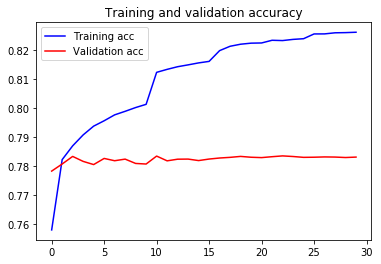

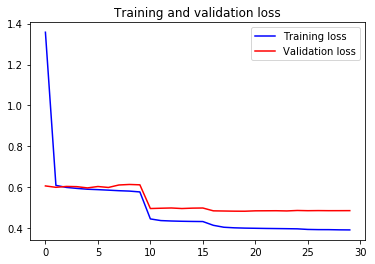

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

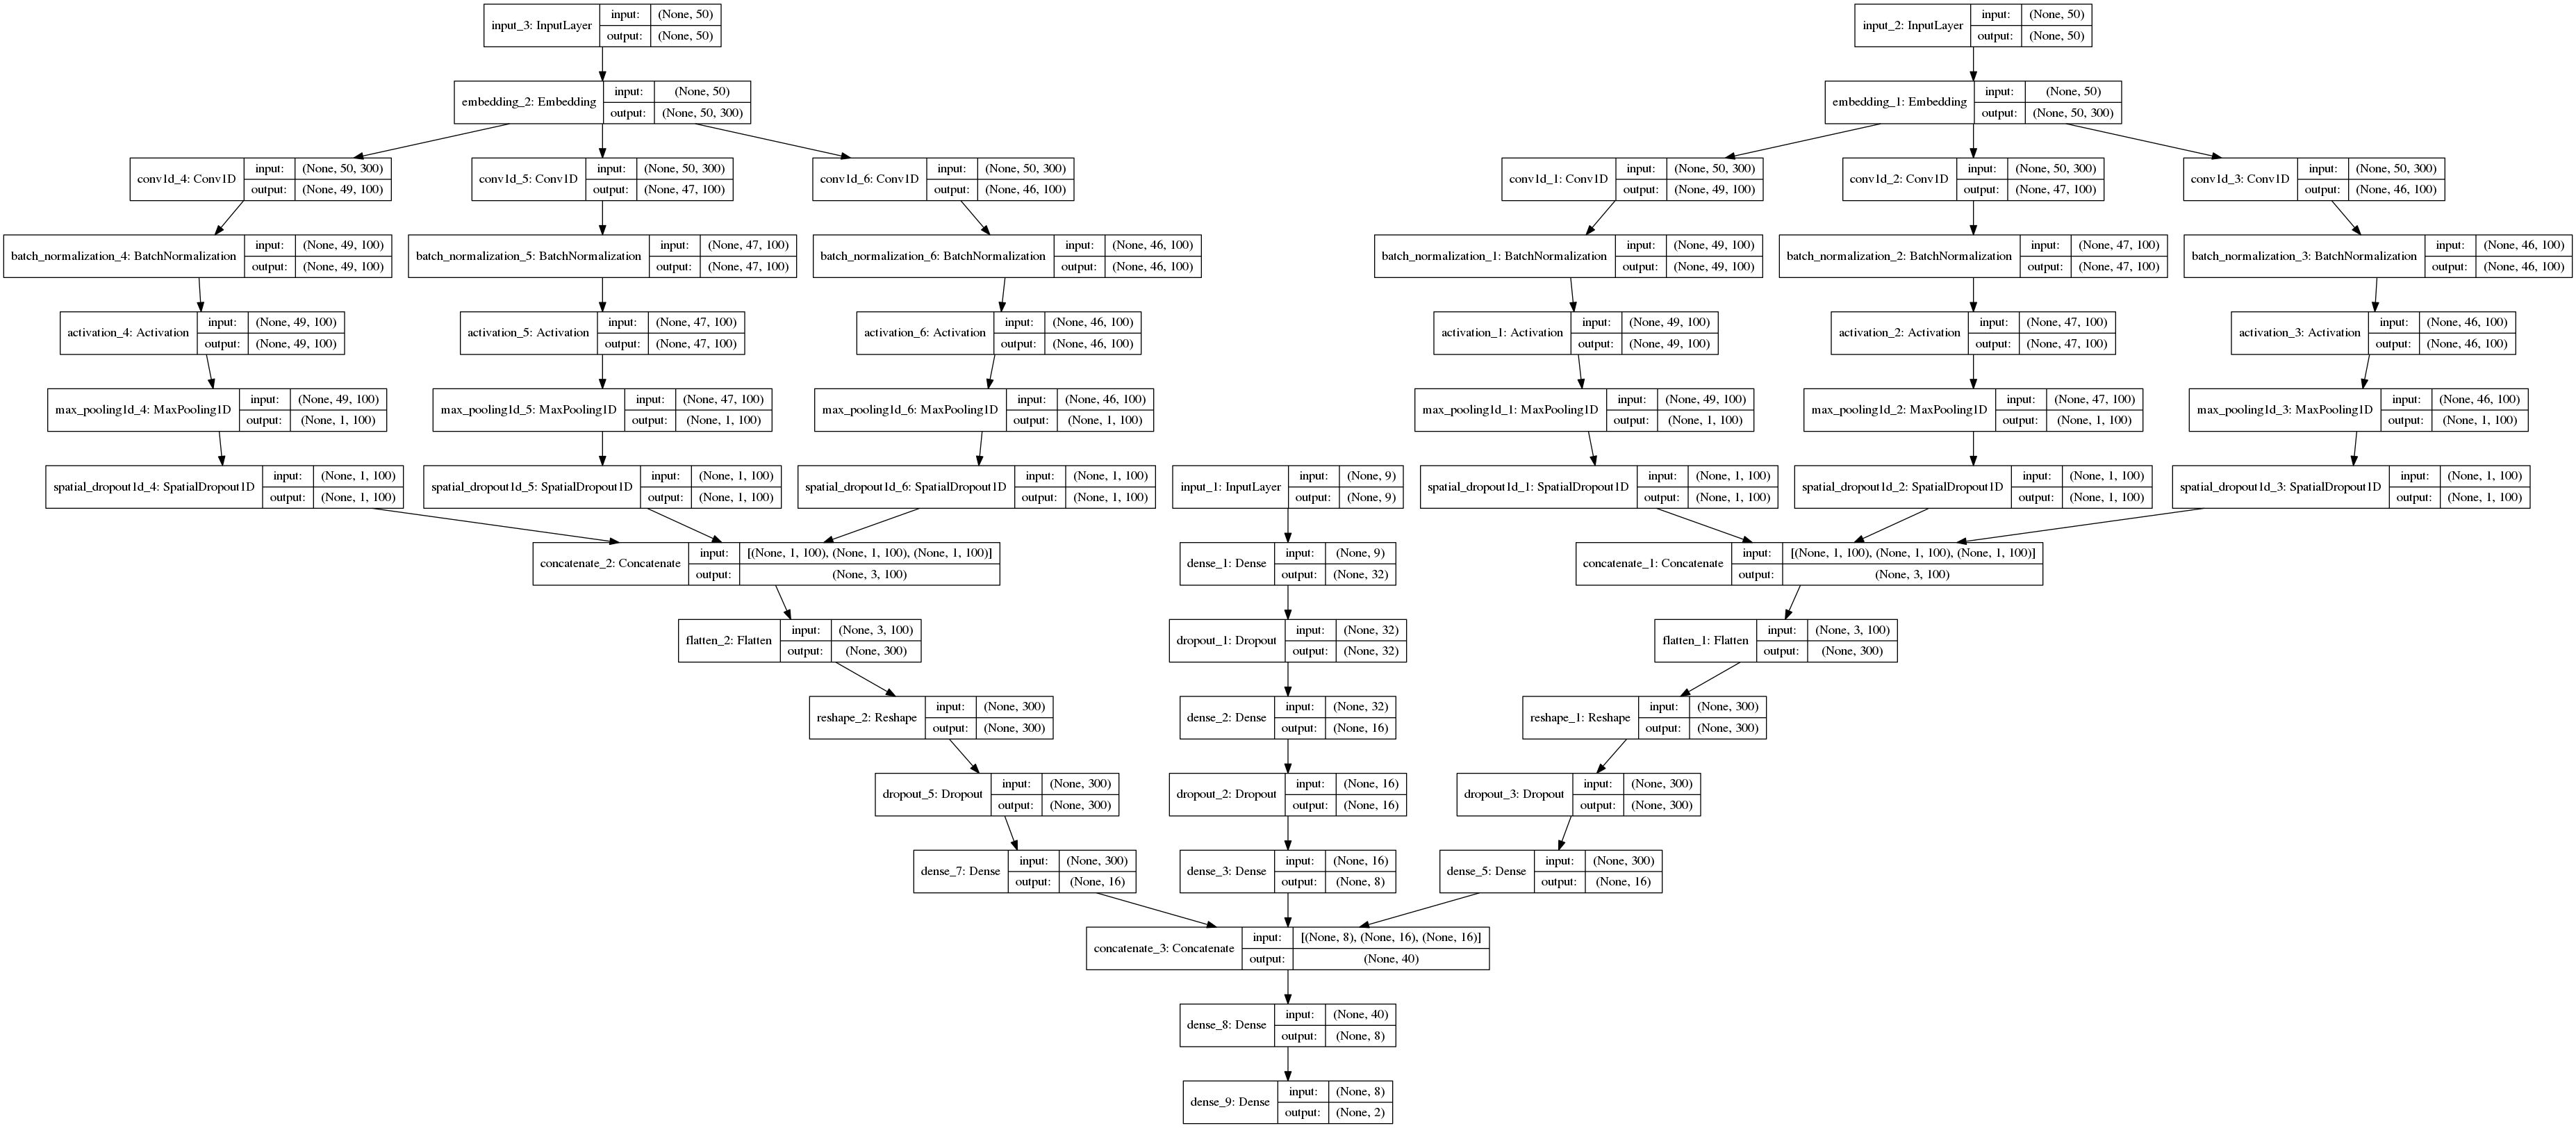

In [41]:
Image("../working/model.png")

In [42]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    return {"score": float(score)}  

predict("@Nintendo I love your games!")

NameError: name 'MAX_SEQUENCE_LENGTH' is not defined